In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)


In [42]:
dataset = pd.read_csv('root2aidata.csv')

In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22704 entries, 0 to 22703
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    22701 non-null  object
 1   Target  22704 non-null  object
dtypes: object(2)
memory usage: 354.9+ KB


In [44]:
dataset['Target'].unique()

array(['Blockchain', 'Bigdata', 'credit reporting', 'Cyber Security',
       'FinTech', 'Microservices', 'Neobanks', 'Robo Advising',
       'Stock Trading', 'Data Security', 'Reg Tech'], dtype=object)

In [45]:
dataset.loc[dataset['Text'].isnull()]

,Text,Target
16661,NaN,Microservices
16940,NaN,Microservices
17073,NaN,Microservices


In [46]:
dataset['Target'].value_counts()

FinTech             8551
Cyber Security      2640
Bigdata             2267
Reg Tech            2206
credit reporting    1748
Blockchain          1375
Neobanks            1069
Microservices        977
Stock Trading        787
Robo Advising        737
Data Security        347
Name: Target, dtype: int64

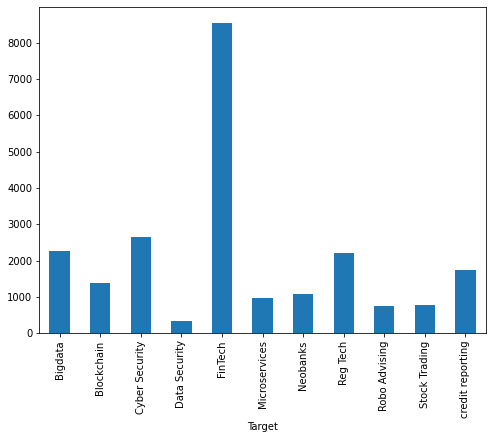

In [47]:
#observing the distribution texts with respect to the target variable 
fig = plt.figure(figsize=(8,6))
dataset.groupby('Target').Text.count().plot.bar(ylim=0)
plt.show()

In [48]:
df = dataset.copy()
cols = ['Target', 'Text']
df = df[cols]


In [49]:
df = df[pd.notnull(df['Text'])]


In [60]:

df['class_id'] = df['Target'].factorize()[0]
class_id_df = df[['Target', 'class_id']].drop_duplicates().sort_values('class_id')
#dictionaries to be used later
class_to_id = dict(class_id_df.values)
id_to_class = dict(class_id_df[['class_id', 'Target']].values)

id_to_class

{0: 'Blockchain',
 1: 'Bigdata',
 2: 'credit reporting',
 3: 'Cyber Security',
 4: 'FinTech',
 5: 'Microservices',
 6: 'Neobanks',
 7: 'Robo Advising',
 8: 'Stock Trading',
 9: 'Data Security',
 10: 'Reg Tech'}

In [61]:
#feature engineering using Term Frequency and Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tf_idf.fit_transform(df.Text).toarray()
labels = df.class_id
features.shape

(22701, 6401)

In [69]:
#to find the grams most correlated to the target using chi2 test
from sklearn.feature_selection import chi2
N = 2
for Target, class_id in sorted(class_to_id.items()):
    features_chi2 = chi2(features, labels == class_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tf_idf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Target))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bigdata':
  . Most correlated unigrams:
. ncbi
. retrieved
  . Most correlated bigrams:
. pmid pubmed
. retrieved october
# 'Blockchain':
  . Most correlated unigrams:
. chit
. permissioned
  . Most correlated bigrams:
. draft discussion
. paper strategy
# 'Cyber Security':
  . Most correlated unigrams:
. para
. security
  . Most correlated bigrams:
. information security
. security digital
# 'Data Security':
  . Most correlated unigrams:
. privacy
. protection
  . Most correlated bigrams:
. personal data
. data protection
# 'FinTech':
  . Most correlated unigrams:
. start
. data
  . Most correlated bigrams:
. financial advisory
. advisory group
# 'Microservices':
  . Most correlated unigrams:
. application
. architecture
  . Most correlated bigrams:
. cloud native
. architectural style
# 'Neobanks':
  . Most correlated unigrams:
. valuation
. starling
  . Most correlated bigrams:
. sanction scanner
. starling bank
# 'Reg Tech':
  . Most correlated unigrams:
. regulators
. regtech
 

In [76]:
features_chi2

(array([0.24159325, 1.79015744, 5.3874167 , ..., 0.35630543, 0.71032569,
        0.31712546]),
 array([0.62305775, 0.18090698, 0.02028248, ..., 0.5505653 , 0.39933571,
        0.57334028]))

# Creating a Multinomial Naive Bayes model and train the tf-idf features on it

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Target'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

## Now looking at some predictions from the training set

In [107]:
print(clf.predict(tfidf_transformer.fit_transform(count_vect.transform(["this type architecture inserts data parallel dbms implements mapreduce hadoop frameworks"]))))

['Bigdata']


In [102]:
df.loc[df["Text"] == "this type architecture inserts data parallel dbms implements mapreduce hadoop frameworks"]

,Target,Text,class_id
2000,Bigdata,this type architecture inserts data parallel dbms implements mapreduce hadoop frameworks,1


In [111]:
df["Text"][10999]

'cent credit card fixed'

In [112]:
print(clf.predict(tfidf_transformer.fit_transform(count_vect.transform(["cent credit card fixed"]))))

['FinTech']


In [113]:
df.loc[df["Text"] == "cent credit card fixed"]

,Target,Text,class_id
10999,FinTech,cent credit card fixed,4


In [103]:
df["Text"][10000]

'this solid platform build trust especially many take encourage competition customer protection'

In [104]:
print(clf.predict(count_vect.transform(['this solid platform build trust especially many take encourage competition customer protection'
])))

['FinTech']


In [105]:
df.loc[df["Text"] == 'this solid platform build trust especially many take encourage competition customer protection'
]

,Target,Text,class_id
10000,FinTech,this solid platform build trust especially many take encourage competition customer protection,4


# Model Selection Stage

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [142]:
X_train_tfidf.shape

(17025, 10207)

In [141]:
features.shape

(22701, 6401)

In [162]:
models = [
    #XGBClassifier(eval_metric='mlogloss'),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter = 300),
]

In [163]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [164]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

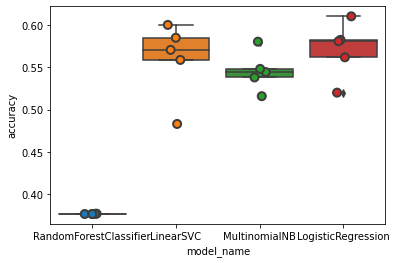

In [166]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [167]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.559582
LogisticRegression        0.571167
MultinomialNB             0.545440
RandomForestClassifier    0.376768
Name: accuracy, dtype: float64

In [159]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.377009
1,RandomForestClassifier,1,0.376652
2,RandomForestClassifier,2,0.376872
3,RandomForestClassifier,3,0.376652
4,RandomForestClassifier,4,0.376652
5,LinearSVC,0,0.483153
6,LinearSVC,1,0.600220
7,LinearSVC,2,0.558811
8,LinearSVC,3,0.570705
9,LinearSVC,4,0.585022


C:\Users\sahil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


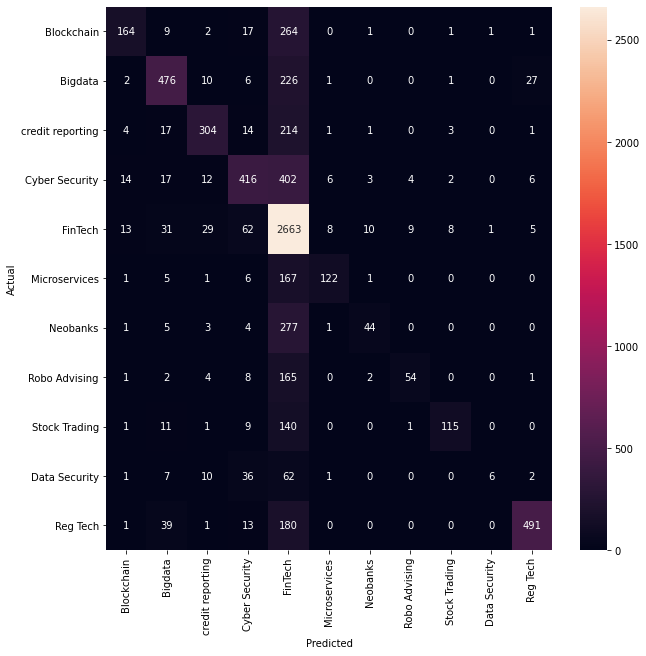

In [168]:
model =  LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_id_df.Target.values, yticklabels=class_id_df.Target.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [170]:
dataset.head(300)

,Text,Target
0,reserve bank forming expert committee based institute development research banking technology study approach distributed ledger technology help support shift,Blockchain
1,director could play role financial system,Blockchain
2,preliminary discuss secure transaction study research payment,Blockchain
3,security indeed prove essential transforming financial system part effort move away heavy reliance cash based,Blockchain
4,bank settlement normally take three days based payment verification technology take less tier security,Blockchain
...,...,...
295,designed reconcile data regularly constantly across network,Blockchain
296,since data reside millions central location data management service,Blockchain
297,result difficult hack,Blockchain
298,public verifiable,Blockchain
